In [0]:
#____________________________________testing model_______________________________________________
from keras.models import model_from_json
import os
from sklearn.datasets import load_files
import numpy as np
import cv2
import tensorflow as tf

In [0]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
raw_data = load_files('/content/drive/My Drive/Colab Notebooks/Data', shuffle=False)
train = raw_data['filenames']
target = raw_data['target']

In [0]:
class Videoto3D:

    def __init__(self,n_channels, width, height, depth,n_videos):
        self.width = width
        self.height = height
        self.depth = depth
        self.n_channels=n_channels
        self.n_videos=n_videos
    
    def video3d(self, filename, color=False, skip=True):
        #filename of the corresponding video
        
        cap = cv2.VideoCapture(filename)
        
        
        nframe = cap.get(cv2.CAP_PROP_FRAME_COUNT)
        
        if skip:
            frames = [x * nframe / self.depth for x in range(1,(self.depth+1))]
        else:
            frames = [x for x in range(self.depth)]
        
        
        frames=frames[(int(len(frames)/2)-5):(int(len(frames)/2)+5)]
        
        framearray = []

        for i in range(len(frames)):
            cap.set(cv2.CAP_PROP_POS_FRAMES, frames[i])
            ret, frame = cap.read()
            frame = cv2.resize(frame, (self.height, self.width))
            #img = cv2.imread('messi5.jpg',0)
            #frame = cv2.Canny(frame,224,224)
            #if color:
            #framearray.append(frame)
              
            #else:
            
            frame=cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
            framearray.append(cv2.cvtColor(frame,cv2.COLOR_GRAY2RGB))
               
        cap.release()
        
        
        
        return np.array(framearray)

In [0]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
vid3d = Videoto3D(3,224, 224, 30,518)
#vid3d = Videoto3D(3,128, 128, 60,300)
X_test=[]
#Y_train=[]
for i in range(0, len(train)):
    X_test.append(vid3d.video3d(train[i]))
    #Y_train.append(target[i])

label_encoder = LabelEncoder()
Y_test = label_encoder.fit_transform(target)
X_test=np.array(X_test)
Y_test=np.array(Y_test)
print(Y_test)

[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3
 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5]


In [0]:
from keras.optimizers import Adam, SGD

json_file = open('/content/drive/My Drive/Colab Notebooks/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/My Drive/Colab Notebooks/model.h5")
loaded_model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=SGD(lr=0.01, momentum=0.7),
                  metrics=['accuracy'])
print("Loaded model")
(loss, accuracy) = loaded_model.evaluate(X_test, Y_test, batch_size=30, verbose=1)
print('Accuracy on test data: {:.2f}%'.format(accuracy * 100))


Loaded model
66/66 [==============================] - 18s 272ms/step
Accuracy on test data: 60.61%


In [0]:
#___________________________Prediction______________

In [0]:
json_file = open('/content/drive/My Drive/Colab Notebooks/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/My Drive/Colab Notebooks/model.h5")
print("Loaded model")
X_pred=vid3d.video3d('/content/drive/My Drive/Colab Notebooks/Data/boxing/person23_boxing_d4_uncomp.avi')
print(X_pred.shape)
video=1
X_pred=X_pred.reshape((video,X_pred.shape[0],X_pred.shape[1],X_pred.shape[2],X_pred.shape[3]))
res=loaded_model.predict(X_pred)
r1=np.argmax(res)
print(r1)
Y_pred=['boxing','handclapping','handwaving','jogging','running','walking']
print("activity: "+Y_pred[r1])

Loaded model
(10, 224, 224, 3)
0
activity: boxing


In [0]:
#__________________________________________confusion matrix____________________________________________________________
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
def confusion_matrix_plot(cm, classes,title='Confusion Matrix', 
                          cmap=plt.cm.Blues):
  plt.subplots(1, 1, figsize=(8, 8))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
    horizontalalignment="center",
    color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

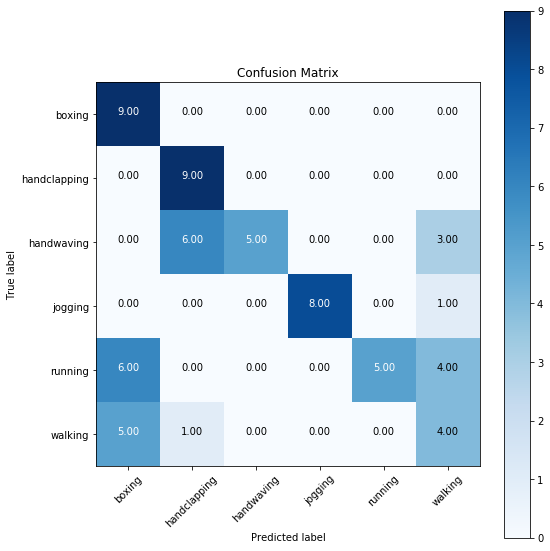

In [0]:
from sklearn.metrics import confusion_matrix

# Getting the predictions of our Model
predictions = loaded_model.predict_classes(X_test)

# Constructing the Confusion Matrix
model_cnf_matrix = confusion_matrix(Y_test, predictions.round())

# PLotting the confusion matrix of our model
confusion_matrix_plot = confusion_matrix_plot(model_cnf_matrix, classes=['boxing', 'handclapping', 'handwaving', 'jogging', 'running', 'walking']) 
